# Lab 1: paths between minima of neural nets.

### 10 points total + 2 extra points.

*Disclaimer: we've tested the lab, however, if something doesn't work, you are free to change the given template.*

## Plan:

In this lab we are going to do some quantitative research concerning the loss landscape of neural nets. Specifically, we will try to answer the following two questions:
1. How "chaotic" is the loss landscape? Specifically, how common are local minima and saddle points?
2. Are local minima found by stochastic gradient descent (SGD) isolated or are they connected with a valley of small loss?

First, following [Goodfellow et al. (2014)](https://arxiv.org/abs/1412.6544), we are going to look at the loss on the linear segment connecting two different points:
1. Two random points;
2. Minimum found by SGD and its initialization point;
3. Minimum found by SGD and some other initialization point;
4. Two different minima found by SGD.

Then, following [Garipov et al. (2018)](https://arxiv.org/abs/1802.10026), we are going to fit the valley of small loss between two minima found by SGD (if it exists) with a simple curve.

In [1]:
import random
from typing import List, Tuple
from time import time
from copy import copy, deepcopy

import numpy as np

# We use pytorch 1.0 in our labs (we didn't test on other versions); 
# installation instructions are here: https://pytorch.org/ 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.distributions as distr
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else 'cpu')

## Part 0: preparation

Load MNIST dataset:

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

input_shape = [1, 28, 28]
output_size = 10 # number of classes in MNIST
batch_size = 128 # you can change this number

dataloader_kwargs = {'num_workers': 0, 'pin_memory': True} if USE_CUDA else {}

dataset_train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
dataset_test = MNIST('./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, **dataloader_kwargs)

test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, **dataloader_kwargs)

In [3]:
class ReshapeLayer(nn.Module):
    """
    
A layer that accepts a tensor of shape [batch_size, *valid_shape]\
and returns a tensor of shape [batch_size, *target_shape],\
where valid_shape is compatible with target_shape.

    """
    def __init__(self, *target_shape):
        super(ReshapeLayer, self).__init__()
        self.target_shape = target_shape

    def forward(self, x):
        return x.view(x.shape[0], *self.target_shape)

We will experiment with a simple multi-layer fully-connected network:

In [4]:
class ClassifierFC(nn.Module):
    """
    
A fully-connected network with 'num_hidden' hidden layers of 'hidden_dim' neurons each,\
alternated with instances of 'nonlinearity'.
    
    """
    def __init__(self, input_shape, output_size, hidden_dim=50, num_hidden=1, nonlinearity=nn.ReLU):
        super(type(self), self).__init__()
        assert num_hidden >= 1, "the case 'hum_hidden' = 0 is not implemented"
        input_size = int(np.prod(input_shape))
        self.layers = nn.ModuleList([
            ReshapeLayer(input_size),
            nn.Linear(input_size, hidden_dim),
            nonlinearity()
        ])
        for _ in range(num_hidden-1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nonlinearity())
        self.layers.append(nn.Linear(hidden_dim, output_size))
        
    def forward(self, X):
        """

Forward pass through the network. Returns logits.
Expected input shape: [batch_size, *self.input_shape]
Output shape: [batch_size, output_size].

        """
        for layer in self.layers:
            X = layer(X)
        return X

In [5]:
class NullContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

This is our main train/validation routine:

In [6]:
def perform_epoch(model, loader, loss_function, optimizer=None):
    """

Performs one training or testing epoch, returns a tuple of mean loss and mean accuracy.\
If 'optimizer' is not None, performs an optimization step.

    """
    is_train = optimizer is not None
    
    if is_train:
        model.train()
    else:
        model.eval()

    cum_loss = 0
    cum_acc = 0
    cum_batch_size = 0

    with NullContext() if is_train else torch.no_grad():
        for X, y in loader:
            batch_size = X.shape[0]
            cum_batch_size += batch_size

            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            loss = loss_function(logits, y)
            cum_loss += loss.item() * batch_size

            acc = torch.mean((torch.max(logits, dim=-1)[1] == y).float())
            cum_acc += acc.item() * batch_size

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    mean_loss = cum_loss / cum_batch_size
    mean_acc = cum_acc / cum_batch_size

    return mean_loss, mean_acc

## Part 1: Straight path between minima

In [7]:
num_minima = 2

state_dicts_at_minima = []
state_dicts_at_inits = []

### Task 1.1 (1 point)
Define your network. Train the network twice. Try to achieve 100% **train** accuracy (you'll probably have to decay your learning rate in some way). Save weights at initialization to *state_dicts_at_inits* and trained weights to *state_dicts_at_minima*.

*Remark: why do we need 100% train accuracy? Empirically, the default network (1 hidden layer with 64 neurons and ReLU nonlinearity) always achieves 100% train accuracy when properly trained (with decaying learning rate etc.), and optimization becomes easier when the network grows larger (but not too large). So, if you didn't achieve it, you are either in a "bad" local minimum, or you haven't trained your network hard enough (or, simply, you have a bug). According to our observations, the first alternative is quite unlikely for the default network. Hence being below 100% train accuracy mean being far from minimum.*

*Remark2. If you didn't achieve 100% train accuracy, and you are sure that you actually converged to a local minimum, please, save the result, weights of the network, network specification, random seed, etc; everything to reproduce this; and let me know.*

In [8]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.9**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [9]:
num_epochs = 100 # you can change this number

for minimum_idx in range(num_minima):
    model = ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)
    
    # The model state (its weights, in particular) is stored in model.state_dict();
    # you can print it somewhere, if you are curious.
    # Here we append our freshly-initialized model state to state_dicts_at_inits:
    state_dicts_at_inits.append(deepcopy(model.state_dict()))

    loss_function = nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), momentum=1., lr=0.001)
    for epoch in range(num_epochs):
        optimizer = exp_lr_scheduler(optimizer, epoch)
        loss, acc = perform_epoch(model, train_loader, loss_function, optimizer=optimizer)
        print('Epoch - {} : loss {}, accuracy {}'.format(epoch+1, loss, acc))
    state_dicts_at_minima.append(deepcopy(model.state_dict()))

LR is set to 0.001
Epoch - 1 : loss 0.4793799915790558, accuracy 0.8758166666666667
Epoch - 2 : loss 0.2295874747991562, accuracy 0.9351333333651225
Epoch - 3 : loss 0.17681840550899505, accuracy 0.9495333333333333
Epoch - 4 : loss 0.14454023155371348, accuracy 0.9587333333333333
Epoch - 5 : loss 0.12286158188581467, accuracy 0.9647500000317891
Epoch - 6 : loss 0.10452793920437495, accuracy 0.9697500000635783
Epoch - 7 : loss 0.09118650218049686, accuracy 0.9738500000635782
LR is set to 0.0009000000000000001
Epoch - 8 : loss 0.07963338897625605, accuracy 0.9770333333333333
Epoch - 9 : loss 0.07133159544666608, accuracy 0.9794833333969116
Epoch - 10 : loss 0.06436500699321429, accuracy 0.9815500000317892
Epoch - 11 : loss 0.05813883602221807, accuracy 0.9834000000635783
Epoch - 12 : loss 0.05339329112768173, accuracy 0.9847000000317891
Epoch - 13 : loss 0.04796797858874003, accuracy 0.9864000000635783
Epoch - 14 : loss 0.043561726733048756, accuracy 0.9879
LR is set to 0.000810000000000

Epoch - 24 : loss 0.01800573569238186, accuracy 0.9963000000635783
Epoch - 25 : loss 0.016365210152169067, accuracy 0.9966500000635783
Epoch - 26 : loss 0.01529197982052962, accuracy 0.997
Epoch - 27 : loss 0.013588559467097123, accuracy 0.99755
Epoch - 28 : loss 0.012919618146618208, accuracy 0.9977000000635783
LR is set to 0.0006561000000000001
Epoch - 29 : loss 0.011498414436976115, accuracy 0.998216666730245
Epoch - 30 : loss 0.010493825263530016, accuracy 0.9983166666666666
Epoch - 31 : loss 0.009709464665750662, accuracy 0.998516666730245
Epoch - 32 : loss 0.009071951807041963, accuracy 0.9988
Epoch - 33 : loss 0.008209292647739251, accuracy 0.9989
Epoch - 34 : loss 0.007867825480674703, accuracy 0.9988333333333334
Epoch - 35 : loss 0.006982878466447195, accuracy 0.9992500000635783
LR is set to 0.00059049
Epoch - 36 : loss 0.006428216102843483, accuracy 0.9992333333333333
Epoch - 37 : loss 0.0056935809845725695, accuracy 0.99955
Epoch - 38 : loss 0.0053424452185630794, accuracy 0

### Task 1.2 (2 points)
Compute train and test loss and accuracy on a straight line connecting two of the previously stored states. Plot the result.

In [16]:
state_dicts_at_minima[0].keys()

odict_keys(['layers.1.weight', 'layers.1.bias', 'layers.3.weight', 'layers.3.bias'])

In [11]:
from collections import OrderedDict

In [102]:
def linear_combination_state_dicts(t1, t2, state_dict_a, state_dict_b):
    state_dict = OrderedDict()
    for key in state_dict_a:
        state_dict[key] = t1*state_dict_a[key] + t2*state_dict_b[key]
    return state_dict

In [103]:
def interpolate_between_state_dicts(t, state_dict_a, state_dict_b):
    return linear_combination_state_dicts(t, 1-t, state_dict_a, state_dict_b)

In [104]:
interpolate_between_state_dicts(0.5, state_dicts_at_minima[0], state_dicts_at_minima[1])

OrderedDict([('layers.1.weight',
              tensor([[-0.0013,  0.0217, -0.0189,  ..., -0.0195, -0.0074, -0.0084],
                      [-0.0074, -0.0060,  0.0107,  ..., -0.0165, -0.0149,  0.0196],
                      [ 0.0132,  0.0158,  0.0127,  ..., -0.0197,  0.0017,  0.0167],
                      ...,
                      [-0.0046, -0.0115,  0.0164,  ...,  0.0192, -0.0031,  0.0186],
                      [ 0.0254,  0.0056,  0.0083,  ..., -0.0076,  0.0204, -0.0063],
                      [ 0.0290, -0.0085,  0.0158,  ...,  0.0148, -0.0187, -0.0104]],
                     device='cuda:0')),
             ('layers.1.bias',
              tensor([-0.0365,  0.2802,  0.0922,  0.2701,  0.2055,  0.0543,  0.2396,  0.0286,
                       0.4332,  0.0582,  0.0788,  0.1230, -0.1202, -0.1063, -0.1516,  0.0949,
                       0.1436,  0.4375, -0.0351,  0.0401, -0.0264, -0.0489,  0.1556,  0.0376,
                       0.1244, -0.1352,  0.2126,  0.2215,  0.1127, -0.1090, -0.177

In [19]:
train_losses = {}
train_accs = {}
test_losses = {}
test_accs = {}

In [20]:
# It is interesting to slightly extend the segment between two minima:
ts = np.linspace(0, 1.5, num=30)

In [26]:
from tqdm import tqdm

In [28]:
model = ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)

In [29]:
mode = 'linear_combination_of_two_minima'

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []

for t in tqdm(ts):
    state_dict = interpolate_between_state_dicts(t, state_dicts_at_minima[0], state_dicts_at_minima[1])
    model.load_state_dict(state_dict)
    loss, acc = perform_epoch(model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(loss)
    train_accs[mode].append(acc)
    
    loss, acc = perform_epoch(model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(loss)
    test_accs[mode].append(acc)
    
    # YOUR CODE: compute train and test loss and accuracy 
    # for a linear combination of model weights at two previously found minima 
    # with coefficients t and 1-t

100%|██████████| 30/30 [01:37<00:00,  3.23s/it]


In [31]:
from matplotlib import pyplot as plt

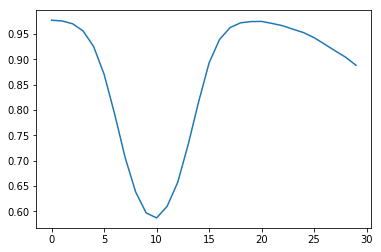

In [33]:
plt.plot(test_accs[mode])

In [34]:
mode = 'linear_combination_of_minimum_and_init'

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []

for t in tqdm(ts):
    state_dict = interpolate_between_state_dicts(t, state_dicts_at_minima[0], state_dicts_at_inits[0])
    model.load_state_dict(state_dict)
    loss, acc = perform_epoch(model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(loss)
    train_accs[mode].append(acc)
    
    loss, acc = perform_epoch(model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(loss)
    test_accs[mode].append(acc)
    
    # YOUR CODE: compute train and test loss and accuracy 
    # for a linear combination of model weights at two previously found minima 
    # with coefficients t and 1-t

100%|██████████| 30/30 [01:38<00:00,  3.26s/it]


In [35]:
rand_model = ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)
rand_state_dict = deepcopy(rand_model.state_dict())

In [37]:
mode = 'linear_combination_of_minimum_and_random'

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []

for t in tqdm(ts):
    state_dict = interpolate_between_state_dicts(t, state_dicts_at_minima[0], rand_state_dict)
    model.load_state_dict(state_dict)
    loss, acc = perform_epoch(model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(loss)
    train_accs[mode].append(acc)
    
    loss, acc = perform_epoch(model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(loss)
    test_accs[mode].append(acc)
    

# YOUR CODE: the same, but interpolate between one of the minima and initialization for another minimum

100%|██████████| 30/30 [01:38<00:00,  3.24s/it]


In [38]:
rand_model = ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)
rand_state_dict_second = deepcopy(rand_model.state_dict())

In [60]:
mode = 'linear_combination_of_two_randoms'

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []

for t in tqdm(ts):
    state_dict = interpolate_between_state_dicts(t, rand_state_dict, rand_state_dict_second)
    model.load_state_dict(state_dict)
    loss, acc = perform_epoch(model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(loss)
    train_accs[mode].append(acc)
    
    loss, acc = perform_epoch(model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(loss)
    test_accs[mode].append(acc)

# YOUR CODE: the same, but interpolate between two pre-saved weight initializations

100%|██████████| 30/30 [01:38<00:00,  3.27s/it]


Plot the corresponding results:

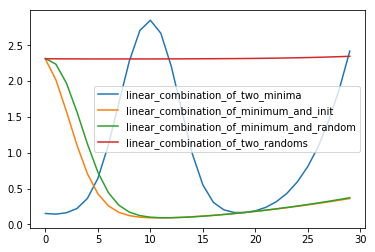

In [85]:
for key in test_losses:
    plt.plot(test_losses[key], label=key)
plt.legend()
plt.show()

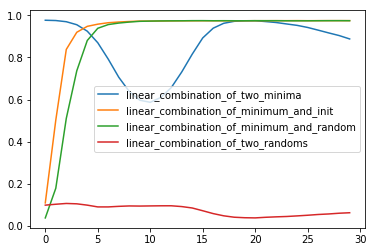

In [64]:
for key in test_losses:
    plt.plot(test_accs[key], label=key)
plt.legend()
plt.show()

Charactarize loss and accuracy on segments you've just tried.

Questions to think about:
* Can you characterize the loss landscape as "chaotic" or "regular"?
* Do train and test curves look quantitatively same or differently?

## Part 2: Constructing an optimal one-bend chain connecting two minima

Suppose we have two points $w_1$ and $w_2$ which are both minima of a loss of our network on the train dataset $\mathcal{L}_{train}(w)$. 
Let $\theta$ be some point in the weight-space.
Let $\phi_{\theta}(t)$ be a chain composed of two linear segments: first one connecting $w_1$ and $\theta$, and the second one connecting $\theta$ and $w_2$. 
We choose parameterization such that $\phi_{\theta}(0) = w_1$, $\phi_{\theta}(1) = w_2$ and $\phi_{\theta}(0.5) = \theta$.

Recall we are looking for a valley of small loss.
We are going to approximate this valley with our one-bend chain.
In order to do this we are going to minimize an average loss over the chain:
$$
\mathcal{L}_{chain}(\theta) = \mathbb{E}_{w \sim U(\phi_{\theta})} \mathcal{L}_{train}(w) \to \min_{\theta},
$$
where $U(\phi_{\theta})$ denotes a uniform distribution of weights over chain.

It is not easy to optimize this objective with SGD. That's why we further follow [Garipov et al. (2018)](https://arxiv.org/abs/1802.10026) to approximate our objective as follows:
$$
\tilde{\mathcal{L}}_{chain}(\theta) = \mathbb{E}_{t \sim U[0,1]} \mathcal{L}_{train}(\phi_\theta(t)) \to \min_{\theta}.
$$

The latter objective could be easily optimized with gradient methods:
$$
\nabla_{\theta} \tilde{\mathcal{L}}_{chain}(\theta) = \mathbb{E}_{t \sim U[0,1]} \nabla_{\theta} \mathcal{L}_{train}(\phi_\theta(t)),
$$
where we can unbiasedly estimate the expectation over $t$ with Monte-Carlo samples:
$$
\mathbb{E}_{t \sim U[0,1]} \nabla_{\theta} \mathcal{L}_{train}(\phi_\theta(t)) \approx
\nabla_{\theta} \mathcal{L}_{train}(\phi_\theta(\tilde t)), \quad \tilde{t} \sim U[0,1].
$$

### Task 2.1 (1 point)
Derive an exact formula for $\phi_{\theta}(t)$.

$$
φ_θ(t) = 
\begin{cases}
2 (tθ + (0.5 − t) \hat{w}_1),& 0 ≤ t ≤ 0.5,
\\
2 ((t − 0.5) \hat{w}_2 + (1 − t)θ),& 0.5 ≤ t ≤ 1.
\end{cases}
$$


### Task 2.2 (2 points)
Find an optimal bend for two minima found before. Where you able to optimize a bend to small mean loss on a chain?

In [65]:
# Here we initialize state_dict_at_theta as a state dict 
# in the middle of the segment connecting two minima we have previously found;
# theta_params is a list of trainable model weights at theta; these are the weights we are going to optimize:
state_dict_at_theta = OrderedDict()
theta_params = []
for param_key in state_dicts_at_minima[0].keys():
    state_dict_at_theta[param_key] = (state_dicts_at_minima[0][param_key] + state_dicts_at_minima[1][param_key]) / 2
    try:
        state_dict_at_theta[param_key].requires_grad_()
        theta_params.append(state_dict_at_theta[param_key])
    except RuntimeError:
        pass

In [ ]:
def interpolate_between_state_dicts(t, state_dict_a, state_dict_b):
    state_dict = OrderedDict()
    for key in state_dict_a.keys():
        state_dict[key] = state_dict_a[key]*t + state_dict_b[key] * (1 - t)
    # YOUR CODE: compute a linear combination of two state dicts with coefficients t and 1-t
    return state_dict

In [67]:
def get_state_dict_from_chain(t, state_dict_at_w1, state_dict_at_w2, state_dict_at_theta):
    state_dict = OrderedDict()
    if t <= 0.5:
        return interpolate_between_state_dicts(2*t, state_dict_at_w1, state_dict_at_theta)
    else:
        return interpolate_between_state_dicts(2*t - 1, state_dict_at_theta, state_dict_at_w2)

In [68]:
# YOUR CODE: create an optimizer and a learning rate scheduler for theta_params we are going to optimize
num_epochs = 100 # you are free to change this number

model = ClassifierFC(input_shape, output_size, num_hidden=1, hidden_dim=64, nonlinearity=nn.ReLU).to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):    
    optimizer = exp_lr_scheduler(optimizer, epoch)
    print('epoch', epoch+1)

    cum_loss = 0
    cum_acc = 0
    cum_batch_size = 0

    model.eval()
    for X, y in train_loader:
        batch_size = X.shape[0]
        cum_batch_size += batch_size

        X = X.to(device)
        y = y.to(device)
        
        t = np.random.rand()
        state_dict_at_theta = deepcopy(model.state_dict())
        state_dict = get_state_dict_from_chain(t, state_dicts_at_minima[0], state_dicts_at_minima[1], state_dict_at_theta)
        model.load_state_dict(state_dict)
        # YOUR CODE: set state_dict of a model to a point on a chain that corresponds to t
        # HINT: use model.load_state_dict()

        logits = model(X)
        loss = loss_function(logits, y)
        cum_loss += loss.item() * batch_size

        acc = torch.mean((torch.max(logits, dim=-1)[1] == y).float())
        cum_acc += acc.item() * batch_size

        optimizer.zero_grad()
        loss.backward()
        model.load_state_dict(state_dict_at_theta)
        # YOUR CODE: first, compute gradients of train loss wrt model weights at \phi_{\theta}(t);
        # then, given them, compute gradients of train loss at \phi_{\theta}(t) wrt \theta
        optimizer.step()

    mean_train_loss = cum_loss / cum_batch_size
    mean_train_acc = cum_acc / cum_batch_size

    print('train:')
    print('loss = {:.4f}; acc = {:.2f}'.format(mean_train_loss, mean_train_acc*100))

    # Uncomment if you use lr scheduler:
    #scheduler.step()

LR is set to 0.001
epoch 1
train:
loss = 0.1933; acc = 96.16
epoch 2
train:
loss = 0.0938; acc = 97.59
epoch 3
train:
loss = 0.0795; acc = 97.92
epoch 4
train:
loss = 0.0649; acc = 98.23
epoch 5
train:
loss = 0.0551; acc = 98.47
epoch 6
train:
loss = 0.0537; acc = 98.54
epoch 7
train:
loss = 0.0459; acc = 98.75
LR is set to 0.0009000000000000001
epoch 8
train:
loss = 0.0422; acc = 98.83
epoch 9
train:
loss = 0.0388; acc = 98.94
epoch 10
train:
loss = 0.0373; acc = 98.98
epoch 11
train:
loss = 0.0348; acc = 99.05
epoch 12
train:
loss = 0.0347; acc = 99.08
epoch 13
train:
loss = 0.0341; acc = 99.04
epoch 14
train:
loss = 0.0325; acc = 99.09
LR is set to 0.0008100000000000001
epoch 15
train:
loss = 0.0289; acc = 99.19
epoch 16
train:
loss = 0.0267; acc = 99.27
epoch 17
train:
loss = 0.0277; acc = 99.22
epoch 18
train:
loss = 0.0240; acc = 99.34
epoch 19
train:
loss = 0.0240; acc = 99.34
epoch 20
train:
loss = 0.0223; acc = 99.40
epoch 21
train:
loss = 0.0224; acc = 99.44
LR is set to 0.00

Visualize train and test loss and accuracy on a chain you have found:

In [86]:
mode = '1-bend_chain'

train_losses[mode] = []
train_accs[mode] = []

test_losses[mode] = []
test_accs[mode] = []

for t in tqdm(ts):
    state_dict = get_state_dict_from_chain(t, state_dicts_at_minima[0], state_dicts_at_minima[1], state_dict_at_theta)
    model.load_state_dict(state_dict)
    loss, acc = perform_epoch(model, train_loader, loss_function, optimizer=None)
    train_losses[mode].append(loss)
    train_accs[mode].append(acc)
    
    loss, acc = perform_epoch(model, test_loader, loss_function, optimizer=None)
    test_losses[mode].append(loss)
    test_accs[mode].append(acc)
    # TODO: compute train and test loss and accuracy at the chain you've just found
    # for a given t using formula you've derived

100%|██████████| 30/30 [01:37<00:00,  3.26s/it]


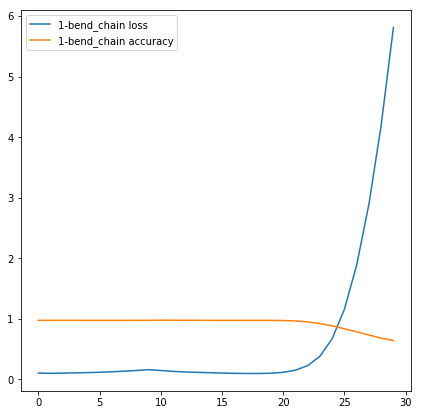

In [87]:
key = '1-bend_chain'
plt.figure(figsize=(7,7))
plt.plot(test_losses[key], label=key+' loss')
plt.plot(test_accs[key], label=key+' accuracy')
plt.legend()
plt.show()

Compare losses / accuracy on a bend and on a segment connecting two minima:

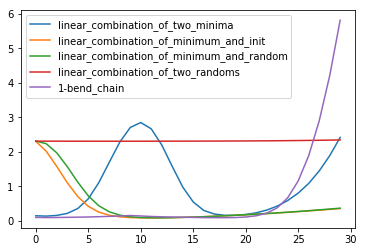

In [88]:
for key in test_losses:
    plt.plot(test_losses[key], label=key)
plt.legend()
plt.show()

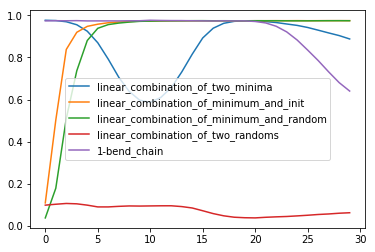

In [89]:
for key in test_losses:
    plt.plot(test_accs[key], label=key)
plt.legend()
plt.show()

### Task 2.3 (1 point):
Ok, we've just found an optimal bend $\theta$ for two different minima $w_1$ and $w_2$.
Define $u = w_2 - w_1$ and $v = \theta - w_1$.
As long as $\theta$ doesn't lie on a straight line connecting $w_1$ and $w_2$, our chain lie on a plane spanned by vectors $u$ and $v$.

However, in order to visualize loss on this plane nicely, we need to derive an orthogonal basis there.
Vectors $u$ and $v$ are not generally orthogonal.

First, derive two vectors $\hat u$ and $\hat v$ that span the same plane as $u$ and $v$ while being orthogonal.

In [120]:
u_state_dict = OrderedDict()
v_state_dict = OrderedDict()

with torch.no_grad():
    for param_key in state_dict_at_theta.keys():
        u_state_dict[param_key] = state_dicts_at_minima[1][param_key] - state_dicts_at_minima[0][param_key]
        v_state_dict[param_key] = state_dict_at_theta[param_key] - state_dicts_at_minima[0][param_key]

hat_u_state_dict = OrderedDict()
hat_v_state_dict = OrderedDict()


def scalar_prod(a, b):
    flatten_a = []
    for key in a:
        flatten_a.append(a[key].view(-1))
    flatten_a = torch.cat(flatten_a, -1)
    
    flatten_b = []
    for key in b:
        flatten_b.append(b[key].view(-1))
    flatten_b = torch.cat(flatten_b, -1)
    coef = torch.dot(flatten_a, flatten_b) / torch.dot(flatten_a, flatten_a)
    
    hat_b = OrderedDict()
    for key in a:
        hat_b[key] = a[key]*coef + b[key]    
    return a, hat_b

hat_u, hat_v = scalar_prod(u_state_dict, v_state_dict)

# YOUR CODE: compute hat_u_state_dict and hat_v_state_dict using formula you've just derived

### Task 2.4 (1 point)
Visualize your network train loss on a plane spanned by $\hat u$ and $\hat v$; visualize your chain on the same plot. Do you see a valley of small loss? Does your chain approximate this valley well?

In [126]:
train_losses_grid = []
train_accs_grid = []

test_losses_grid = []
test_accs_grid = []

ts = np.linspace(-1.5, 2.5, num=30) # this specification heavily depends on lenghts of vectors \hat u and \hat v;
ss = np.linspace(-1.5, 2.5, num=30) # hence you probably will need to modify it

for t in tqdm(ts):
    train_losses_grid.append([])
    train_accs_grid.append([])
    
    test_losses_grid.append([])
    test_accs_grid.append([])
    
    for s in tqdm(ss):
        state_dict_u = linear_combination_state_dicts(1, t, state_dicts_at_minima[0], hat_u)
        state_dict_v = linear_combination_state_dicts(1, s, state_dicts_at_minima[0], hat_v)
        state_dict = linear_combination_state_dicts(1, 1, state_dict_u, state_dict_v)
        
        model.load_state_dict(state_dict)
        loss, acc = perform_epoch(model, train_loader, loss_function, optimizer=None)
        train_losses_grid[-1].append(loss)
        train_accs_grid[-1].append(acc)

        loss, acc = perform_epoch(model, test_loader, loss_function, optimizer=None)
        test_losses_grid[-1].append(loss)
        test_accs_grid[-1].append(acc)
        # YOUR CODE: compute state_dict on a plane spanned by hat_u_state_dict and hat_v_state_dict with coeffs t and s;
        # load it to the model; compute train and test loss and accuracy at this point
        # HINT: evaluating model on a whole train/test dataset can take too much time;
        # if iterations run to slowly, you can evaluate your model on some fixed subset of each dataset.



  0%|          | 0/30 [00:00<?, ?it/s]


  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:03<01:34,  3.26s/it]


  7%|▋         | 2/30 [00:06<01:31,  3.26s/it]


 10%|█         | 3/30 [00:09<01:27,  3.25s/it]


 13%|█▎        | 4/30 [00:12<01:24,  3.25s/it]


 17%|█▋        | 5/30 [00:16<01:21,  3.25s/it]


 20%|██        | 6/30 [00:19<01:17,  3.25s/it]


 23%|██▎       | 7/30 [00:22<01:14,  3.25s/it]


 27%|██▋       | 8/30 [00:25<01:11,  3.25s/it]


 30%|███       | 9/30 [00:29<01:08,  3.24s/it]


 33%|███▎      | 10/30 [00:32<01:04,  3.24s/it]


 37%|███▋      | 11/30 [00:35<01:01,  3.24s/it]


 40%|████      | 12/30 [00:38<00:58,  3.24s/it]


 43%|████▎     | 13/30 [00:42<00:55,  3.24s/it]


 47%|████▋     | 14/30 [00:45<00:51,  3.24s/it]


 50%|█████     | 15/30 [00:48<00:48,  3.24s/it]


 53%|█████▎    | 16/30 [00:51<00:45,  3.24s/it]


 57%|█████▋    | 17/30 [00:55<00:42,  3.24s/it]


 60%|██████    | 18/30 [00:58<00:38,  3.24s/it]


 63%|██████▎   | 19/30 [0

 37%|███▋      | 11/30 [00:37<01:04,  3.39s/it]


 40%|████      | 12/30 [00:40<01:01,  3.42s/it]


 43%|████▎     | 13/30 [00:44<00:58,  3.42s/it]


 47%|████▋     | 14/30 [00:47<00:54,  3.42s/it]


 50%|█████     | 15/30 [00:51<00:51,  3.41s/it]


 53%|█████▎    | 16/30 [00:54<00:47,  3.40s/it]


 57%|█████▋    | 17/30 [00:57<00:44,  3.39s/it]


 60%|██████    | 18/30 [01:01<00:40,  3.39s/it]


 63%|██████▎   | 19/30 [01:04<00:37,  3.38s/it]


 67%|██████▋   | 20/30 [01:07<00:33,  3.37s/it]


 70%|███████   | 21/30 [01:11<00:30,  3.37s/it]


 73%|███████▎  | 22/30 [01:14<00:26,  3.37s/it]


 77%|███████▋  | 23/30 [01:18<00:23,  3.37s/it]


 80%|████████  | 24/30 [01:21<00:20,  3.38s/it]


 83%|████████▎ | 25/30 [01:24<00:16,  3.38s/it]


 87%|████████▋ | 26/30 [01:28<00:13,  3.38s/it]


 90%|█████████ | 27/30 [01:31<00:10,  3.38s/it]


 93%|█████████▎| 28/30 [01:34<00:06,  3.38s/it]


 97%|█████████▋| 29/30 [01:38<00:03,  3.37s/it]


100%|██████████| 30/30 [01:41<00:00,  3.37s/it]




 73%|███████▎  | 22/30 [01:13<00:26,  3.33s/it]


 77%|███████▋  | 23/30 [01:17<00:23,  3.33s/it]


 80%|████████  | 24/30 [01:20<00:19,  3.33s/it]


 83%|████████▎ | 25/30 [01:23<00:16,  3.33s/it]


 87%|████████▋ | 26/30 [01:27<00:13,  3.34s/it]


 90%|█████████ | 27/30 [01:30<00:10,  3.34s/it]


 93%|█████████▎| 28/30 [01:33<00:06,  3.34s/it]


 97%|█████████▋| 29/30 [01:37<00:03,  3.34s/it]


100%|██████████| 30/30 [01:40<00:00,  3.34s/it]




 30%|███       | 9/30 [15:03<35:17, 100.82s/it]


  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:03<01:36,  3.33s/it]


  7%|▋         | 2/30 [00:06<01:33,  3.32s/it]


 10%|█         | 3/30 [00:09<01:29,  3.33s/it]


 13%|█▎        | 4/30 [00:13<01:26,  3.33s/it]


 17%|█▋        | 5/30 [00:16<01:23,  3.33s/it]


 20%|██        | 6/30 [00:19<01:20,  3.33s/it]


 23%|██▎       | 7/30 [00:23<01:16,  3.33s/it]


 27%|██▋       | 8/30 [00:26<01:13,  3.34s/it]


 30%|███       | 9/30 [00:30<01:10,  3.34s/it]


 33%|███▎      |

  3%|▎         | 1/30 [00:03<01:37,  3.37s/it]


  7%|▋         | 2/30 [00:06<01:34,  3.39s/it]


 10%|█         | 3/30 [00:10<01:32,  3.41s/it]


 13%|█▎        | 4/30 [00:13<01:28,  3.41s/it]


 17%|█▋        | 5/30 [00:17<01:24,  3.40s/it]


 20%|██        | 6/30 [00:20<01:21,  3.39s/it]


 23%|██▎       | 7/30 [00:23<01:18,  3.39s/it]


 27%|██▋       | 8/30 [00:27<01:14,  3.38s/it]


 30%|███       | 9/30 [00:30<01:10,  3.38s/it]


 33%|███▎      | 10/30 [00:33<01:07,  3.38s/it]


 37%|███▋      | 11/30 [00:37<01:04,  3.38s/it]


 40%|████      | 12/30 [00:40<01:00,  3.38s/it]


 43%|████▎     | 13/30 [00:44<00:57,  3.38s/it]


 47%|████▋     | 14/30 [00:47<00:54,  3.41s/it]


 50%|█████     | 15/30 [00:51<00:51,  3.42s/it]


 53%|█████▎    | 16/30 [00:54<00:47,  3.42s/it]


 57%|█████▋    | 17/30 [00:57<00:44,  3.40s/it]


 60%|██████    | 18/30 [01:01<00:40,  3.39s/it]


 63%|██████▎   | 19/30 [01:04<00:37,  3.38s/it]


 67%|██████▋   | 20/30 [01:07<00:33,  3.38s/it]


 70%|████

 40%|████      | 12/30 [00:44<01:06,  3.72s/it]


 43%|████▎     | 13/30 [00:48<01:03,  3.71s/it]


 47%|████▋     | 14/30 [00:52<00:59,  3.72s/it]


 50%|█████     | 15/30 [00:56<00:55,  3.72s/it]


 53%|█████▎    | 16/30 [00:59<00:52,  3.71s/it]


 57%|█████▋    | 17/30 [01:03<00:48,  3.71s/it]


 60%|██████    | 18/30 [01:07<00:44,  3.71s/it]


 63%|██████▎   | 19/30 [01:10<00:40,  3.71s/it]


 67%|██████▋   | 20/30 [01:14<00:37,  3.71s/it]


 70%|███████   | 21/30 [01:18<00:33,  3.71s/it]


 73%|███████▎  | 22/30 [01:21<00:29,  3.70s/it]


 77%|███████▋  | 23/30 [01:25<00:25,  3.70s/it]


 80%|████████  | 24/30 [01:29<00:22,  3.70s/it]


 83%|████████▎ | 25/30 [01:33<00:18,  3.71s/it]


 87%|████████▋ | 26/30 [01:36<00:14,  3.71s/it]


 90%|█████████ | 27/30 [01:40<00:11,  3.71s/it]


 93%|█████████▎| 28/30 [01:44<00:07,  3.70s/it]


 97%|█████████▋| 29/30 [01:47<00:03,  3.70s/it]


100%|██████████| 30/30 [01:51<00:00,  3.70s/it]




 60%|██████    | 18/30 [30:51<21:46, 108.87s/it]

 77%|███████▋  | 23/30 [01:25<00:26,  3.76s/it]


 80%|████████  | 24/30 [01:29<00:22,  3.76s/it]


 83%|████████▎ | 25/30 [01:33<00:18,  3.76s/it]


 87%|████████▋ | 26/30 [01:37<00:15,  3.75s/it]


 90%|█████████ | 27/30 [01:40<00:11,  3.74s/it]


 93%|█████████▎| 28/30 [01:44<00:07,  3.74s/it]


 97%|█████████▋| 29/30 [01:48<00:03,  3.74s/it]


100%|██████████| 30/30 [01:52<00:00,  3.77s/it]




 73%|███████▎  | 22/30 [38:20<14:52, 111.53s/it]


  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:03<01:52,  3.88s/it]


  7%|▋         | 2/30 [00:07<01:47,  3.83s/it]


 10%|█         | 3/30 [00:11<01:42,  3.80s/it]


 13%|█▎        | 4/30 [00:15<01:37,  3.77s/it]


 17%|█▋        | 5/30 [00:18<01:32,  3.71s/it]


 20%|██        | 6/30 [00:22<01:27,  3.66s/it]


 23%|██▎       | 7/30 [00:25<01:23,  3.63s/it]


 27%|██▋       | 8/30 [00:29<01:19,  3.60s/it]


 30%|███       | 9/30 [00:32<01:15,  3.59s/it]


 33%|███▎      | 10/30 [00:36<01:11,  3.58s/it]


 37%|███▋      

  7%|▋         | 2/30 [00:07<01:40,  3.58s/it]


 10%|█         | 3/30 [00:10<01:36,  3.58s/it]


 13%|█▎        | 4/30 [00:14<01:33,  3.58s/it]


 17%|█▋        | 5/30 [00:17<01:29,  3.58s/it]


 20%|██        | 6/30 [00:21<01:25,  3.58s/it]


 23%|██▎       | 7/30 [00:25<01:22,  3.58s/it]


 27%|██▋       | 8/30 [00:28<01:18,  3.58s/it]


 30%|███       | 9/30 [00:32<01:15,  3.58s/it]


 33%|███▎      | 10/30 [00:35<01:11,  3.58s/it]


 37%|███▋      | 11/30 [00:39<01:07,  3.54s/it]


 40%|████      | 12/30 [00:42<01:02,  3.47s/it]


 43%|████▎     | 13/30 [00:45<00:58,  3.42s/it]


 47%|████▋     | 14/30 [00:49<00:54,  3.40s/it]


 50%|█████     | 15/30 [00:52<00:50,  3.38s/it]


 53%|█████▎    | 16/30 [00:55<00:47,  3.36s/it]


 57%|█████▋    | 17/30 [00:59<00:43,  3.35s/it]


 60%|██████    | 18/30 [01:02<00:40,  3.34s/it]


 63%|██████▎   | 19/30 [01:05<00:36,  3.34s/it]


 67%|██████▋   | 20/30 [01:09<00:33,  3.33s/it]


 70%|███████   | 21/30 [01:12<00:29,  3.33s/it]


 73%|███

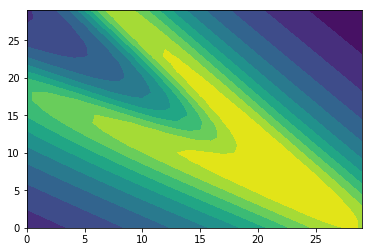

In [137]:
plt.figure()
plt.contourf(-np.log(np.array(test_losses_grid)), levels=10)

/home/phillnik/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


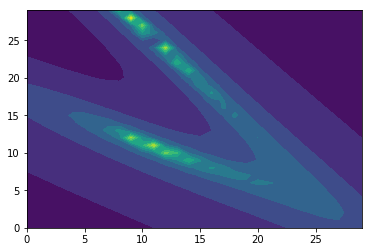

In [157]:
plt.figure()
val = -np.log(np.array(train_losses_grid))
val[val == np.inf] = 0
plt.contourf(val, levels=10)

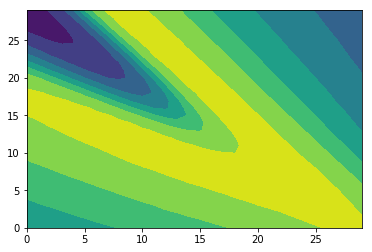

In [145]:
plt.figure()
plt.contourf(np.exp(test_accs_grid))

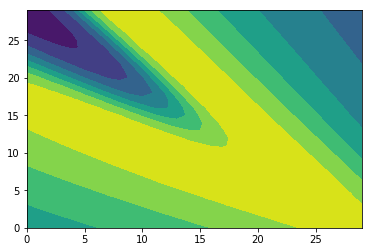

In [147]:
plt.figure()
plt.contourf(np.exp(train_accs_grid))

### Task 3.1 (2 points) 
Try deeper/wider network. Try sigmoid instead of ReLU. Does anything change quantitatively? If yes, indicate what.
You can just clone this notebook and do the same with new network.

### Task 3.2 (optional; 2 points extra) 
Take a serious convolutional architecture with ~~black-jack~~ batch-norms and dropouts, say, VGG (see, https://pytorch.org/docs/stable/torchvision/models.html#id2). Perform the same set of experiments on it.

# Итоги выполнения лабораторной работы

- В выпуклой оболочке двух локальных минимумов существует точка, значение функции потерь в которой существенно больше 
- Существует цепь с одним коленом, полностью лежащая в зоне локальных имнимумов
- Этот паттерн характерен также для сетки с большим количеством уровней и сверточной сети простейшей архитектуры

